<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/3_1_first_classifier_Train_new_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding + first classifier

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold,train_test_split,cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler


In [2]:
data = pd.read_excel("full_data_with_predictions-VETTING.xlsx")

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [3]:
data

,level_0,index,גוף המסמך,מספר הליך,שם הליך,שנת פתיחת ההליך,גוף המסמך חתוך,predicted_probability,prediction_original_model,בקשה לרשות ערעור התקבלה?,טקסט שמצביע על תוצאת בקשה שונה,הערעור התקבל?,"רע""פ בקשה אחרת או דלמטה מיוחד",קידוד,קידוד חוזר,הערות,הערות קידוד חוזר
0,0,2977,"['החלטה בתיק רע""פ 5389/15 בבית המשפט העליון רע...","רע""פ 5389/15","רע""פ 5389/15",2015,"ישראל (24.3.1997); בר""ע 2853/91 פלוני נ\' מדינ...",0.016466,0,נדחה,NaN,NaN,NaN,גל,NaN,NaN,NaN
1,1,2978,"['החלטה בתיק רע""פ 2487/15 בבית המשפט העליון רע...","רע""פ 2487/15","רע""פ 2487/15 אייל אבולפיה נ. עיריית רמת גנ",2015,ופה המוקנית לתובע לצורך מתן מענה לבקשה לביטול ...,0.046868,0,נדחה,NaN,NaN,NaN,דניאל,גל,NaN,NaN
2,2,2979,"['החלטה בתיק רע""פ 4086/15 בבית המשפט העליון רע...","רע""פ 4086/15","רע""פ 4086/15 עבד אגבאריה נ. מדינת ישראל",2015,"וני להכשרת המבנה, הרי שהאינטרס הציבורי של דחיק...",0.029892,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2980,"['פסק דין בתיק רע""פ 8866/15 בבית המשפט העליון ...","רע""פ 8866/15","רע""פ 8866/15 חאזמ רדיע נ. מדינת ישראל",2015,"בין רכיב המאסר לרכיב הפסילה, יש מקום לשוב ולד...",0.958560,1,התקבל,NaN,חלקי,NaN,דניאל,גל,NaN,NaN
4,4,2981,"['החלטה בתיק רע""פ 1094/15 בבית המשפט העליון רע...","רע""פ 1094/15","רע""פ 1094/15 שרית יחיאלוב נ. מדינת ישראל",2015,. עוד אציע לחברותיי כי עונש המאסר בפועל שהושת ...,0.365762,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1473,1473,18335,"['בבית המשפט העליון רע""פ 9288/00 בפני: כבוד הש...","רע""פ 9288/00","רע""פ 9288/00 סמיח עלוש נ. מדינת ישראל",2000,ושהייתה זו בחירתו שלו לטעון לעצמו. אף-על פי-כן...,0.993883,1,התקבל,NaN,התקבל,NaN,גל,דניאל,״ה. הערעור מתקבל במובן זה שהליך הערעור שהוגש ע...,NaN
1474,1474,18340,"[' בבית המשפט העליון רע""פ 4830/00 בפני: כבוד ה...","רע""פ 4830/00","רע""פ 4830/00 יצחק אלקומברה נ. הועדה המקומית לת...",2000,"ב-יפו מיום 5.7.00 בע""פ 70864/00(ב""ש 91552/00) ...",0.503831,1,התקבל,NaN,התקבל,NaN,גל,דניאל,NaN,NaN
1475,1475,18342,"['בבית המשפט העליון בירושלים רע""פ 841/00 בפני:...","רע""פ 841/00","רע""פ 841/00 חברת כורי הצפונ בע""מ נ. מדינת ישראל",2000,"ט המחוזי בחיפה מיום 23.12.99 בע""פ 1008/99 שנית...",0.444206,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1476,1476,18367,"[' בבית המשפט העליון רע""ב 2363/00 בפני: כבוד ה...","רע""פ 2363/00","רע""פ 2363/00 עמרמ כהנ נ. כב' השופט י.כהנ בבית ...",2000,לפטור את המבקש מתשלום אגרהבעתירת אסיר וזאת נוכ...,0.000601,0,נדחה,NaN,NaN,NaN,גל,דניאל,NaN,NaN


In [4]:
data['רע"פ בקשה אחרת או דלמטה מיוחד'].value_counts()
data[(data['רע"פ בקשה אחרת או דלמטה מיוחד'] == 'בקשה אחרת') | (data['רע"פ בקשה אחרת או דלמטה מיוחד'] == 'דלמטה מיוחד')].shape[0]

16

In [5]:
data = data[(data['רע"פ בקשה אחרת או דלמטה מיוחד'] != 'בקשה אחרת') & (data['רע"פ בקשה אחרת או דלמטה מיוחד'] != 'דלמטה מיוחד')]

In [6]:
data = data[(data['בקשה לרשות ערעור התקבלה?'] != 'חלקי') & (data['בקשה לרשות ערעור התקבלה?'] != 'אחר')]

In [7]:
data.dropna(subset=['בקשה לרשות ערעור התקבלה?'],inplace=True)

In [8]:
data['binary_outcome'] = data['בקשה לרשות ערעור התקבלה?'].apply(lambda x: 1 if x == 'התקבל' else 0)

In [9]:
data.shape[0]

239

Confusion Matrix:
[[144  50]
 [  2  43]]


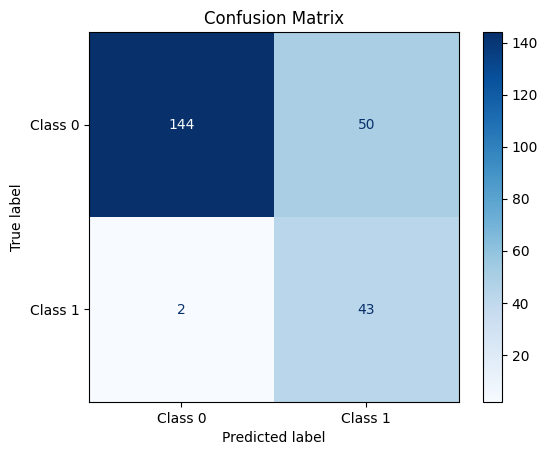

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# יצירת confusion matrix
cm = confusion_matrix(data['binary_outcome'], data['prediction_original_model'])

# הצגת תוצאות confusion matrix
print("Confusion Matrix:")
print(cm)

# ויזואליזציה של confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [11]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import joblib
import pandas as pd

# טעינת המודל והטוקנייזר
tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")

# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Embedding

In [ ]:
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_predict, cross_validate
import joblib


# עדכון עמודת המטרה ואימבדינג לאחר חיתוך הטקסטים
y = data["binary_outcome"].values
embeddings = np.array([get_embeddings(text) for text in data["גוף המסמך"]])


### Train and fit

In [ ]:

# הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(embeddings, y)

# שמירת אינדקסים מקוריים
resampled_indices = undersampler.sample_indices_
joblib.dump(resampled_indices, 'resampled_indices.pkl')

# ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values
if not np.array_equal(y_resampled, binary_outcome_resampled):
    raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

# טוען את המודל
classifier = joblib.load("classifier_model.pkl")

print("המודל נטען בהצלחה.")

# התאמת המודל לנתונים המאוזנים
classifier.fit(X_resampled, y_resampled)

# הגדרת מדדים לקרוס ולידציה
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע Cross Validation
cv_results = cross_validate(classifier, X_resampled, y_resampled, cv=5, scoring=scoring)

# חיזוי תוויות על כל קפל לצורך קונפיושן מטריקס
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)
conf_matrix = confusion_matrix(y_resampled, y_pred)

# הדפסת התוצאות
print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")

# --- לוגיקה למציאת threshold אופטימלי ---
predicted_probabilities = classifier.predict_proba(X_resampled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_resampled, predicted_probabilities)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Threshold אופטימלי לפי F1 Score: {optimal_threshold}")

# שמירת יחס הכיתות המקורי
class_ratio_original = sum(y == 1) / len(y)
print(f"יחס כיתות מקורי (Class 1): {class_ratio_original:.2f}")

# --- שמירת משאבים ---
joblib.dump(classifier, 'classifier_model_double_trained.pkl')
joblib.dump(optimal_threshold, 'optimal_threshold.pkl')
joblib.dump(class_ratio_original, 'class_ratio_original.pkl')

print("המודל והמשאבים נשמרו בהצלחה.")


### FN print


In [ ]:
# חיזוי תוויות על כל קפל לצורך זיהוי FN
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)

# איתור האינדקסים של FN - תווית אמיתית היא 1 והתחזית היא 0
fn_indices = np.where((y_resampled == 1) & (y_pred == 0))[0]

# מיפוי האינדקסים של FN לאינדקסים המקוריים של הנתונים
original_fn_indices = resampled_indices[fn_indices]

# קריאת פסקי הדין והערכים בעמודות "Outcome of case", "binary_outcome", ו-"Predicted" עבור הדוגמאות שמזוהות כ-FN
false_negative_rows = data.iloc[original_fn_indices]
false_negative_predicted = y_pred[fn_indices]  # התחזיות של המודל עבור FN

# ווידוא סינכרון מוחלט של האינדקסים
if len(false_negative_rows) != len(false_negative_predicted):
    raise ValueError("Mismatch between FN rows and predicted labels!")

# הדפסת פסקי הדין של FN בצורה מפורמטת עם הערכים המקוריים והתחזית להשוואה
print("False Negative Cases (True Label: 1, Predicted Label: 0):")
print("=" * 80)

for i, (index, row, predicted) in enumerate(zip(original_fn_indices, false_negative_rows.iterrows(), false_negative_predicted), 1):
    _, row_data = row
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)
    print("\nOriginal Outcome of Case:")
    print(row_data["Outcome of case"])
    print("\nBinary Outcome (True Label):")
    print(row_data["binary_outcome"])
    print("\nPredicted Label:")
    print(predicted)
    print("\nDocument Body:")
    formatted_text = "\n".join(row_data["גוף המסמך"][j:j + 80] for j in range(0, len(row_data["גוף המסמך"]), 80))
    print(formatted_text)
    print("-" * 80)

print("=" * 80)
